#  ATOC5860 Application Lab #3 - eof_analysis_cosineweightingLAST_cartopy
##### Written by Prof. Kay (CU) and Prof. Maroon (UW), with "peer-review" by Dr. Vineel Yettella (ATOC Ph.D. 2018, now at Apple)
##### last updated February 22, 2023 - works with environment atoc5860env2023clean.yml

### LEARNING GOALS:
1) Complete an EOF analysis using the two methods discussed in class: eigenanalysis of the covariance matrix, Singular Value Decomposition (SVD). Compare and make sure you get the same answer.  See how the code works to implement the matrix math in the Barnes notes.
2) Assess the statistical significance of the results, including estimmating the effective sample size (N*). (Lots more to think about here for estimating the autocorrelation and N* in data...!)
3) Provide a qualitative description of the results: What are the eigenvalue,the eigenvector, and the principal component?  What do they mean physically? What do you learn from each one about the space-time structure of the underlying dataset?
4) Assess influence of data preparation on EOF results. What is the influence of the seasonal cycle, detrending, cosine weighting, standardizing (dividing by the standard deviation), anomalizing (removing the mean), (insert your idea here)?

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze observed monthly sea surface temperatures from HadISST (http://www.metoffice.gov.uk/hadobs/hadisst/data/download.html). The data are in netcdf format in a file called HadISST_sst.nc.  Note that this file is ~500 MB so it might take a bit of time to download.  You will subset the data to only look at the North Pacific. Depending on how you prepare your data for analysis – you might expect to see different spatial patterns (eigenvectors) and different time series (principal components).  Some things you might look for in your results are the Pacific Decadal Oscillation, “global warming”, the seasonal cycle, ….  Depending on your data preparation – your hypothesis for what you should see in your EOF analysis should change.  Note: In this dataset - land is NaN, sea ice is -999 – the notebook sets all values over land and sea ice to 0 for the EOF analysis.

### Non-exhaustive Questions to guide your analysis:  
1) **To Start - Execute all code without making any modifications.** Provide a physical interpretation for at least the first two EOFs and principal components (PC).  What do the EOFs (spatial patterns) tell you?  What do the PC time series for the EOFs tell you?  What do you think of the method for estimating the effective sample size (Nstar)?  Can you propose an alternative way to estimate Nstar?  Do you get the same results using eigenanalysis and SVD? If you got a different sign - do you think that is meaningful?

2) Repeat the analysis but this time do not remove the seasonal cycle.  What do you think you will see? Discus your results with your neighbor. How do the EOFs and PC change? Was removing the seasonal cycle from the data useful?  What impacts does removing the seasonal cycle have on your analysis?

3) Repeat the analysis but this time detrend the data.  Discus your results. How do the EOFs and PC change? Was detrending the data useful?   What impacts does detrending have on your analysis?

4) Repeat the analysis but this time do not apply the cosine weighting.  Discuss your results. How do the EOFs and PC change? Was cosine weighting the data useful?  What impacts does cosine weighting have on your analysis? What are examples of analyses where cosine weighting would be more/less important to do?

5) Repeat the analysis but this time do not standardize the data (i.e., comment out dividing by standard deviation).  Discuss your results. How do the EOFs and PC change? Was standardizing the data useful?  What impacts does standardizing the data have on your analysis?

*Note: For steps 2)-5) -- I recommend saving a copy of the notebook and renaming it.  Then you can compare notebooks to assess the influence of the proposed analysis variants.*


## A reminder of the EOF/PCA Analysis Recipe – 5 steps

1) Prepare your data for analysis. What you need to do depends on your data, and on your goals for the EOF analysis. Examples of data prep steps include: a) sub-setting the global data to a smaller domain, b) subtract the mean, c) remove the seasonal or diurnal cycle, d) detrend the data, e) standardizing the data (divide by the standard deviation), f) remove NaN – EOF analysis does not work with missing data, g) cosine weight the data i.e., weight your data by the cosine of latitude to account for the decrease in grid-box area as one approaches the pole.  COSINE WEIGHT SHOULD BE DONE LAST.

2) Calculate the EOFs and PCs using either or both methods: a) Eigenanalysis of the covariance matrix, b) Singular Value Decomposition (SVD).

3) Plot the first 10 eigenvalues (scaled as the percent variance explained) in order of variance explained.  Add error bars following North et al. 1982.  Describe how you determined the effective degrees of freedom N*. How many statistically significant EOFs are there? 

4) Plot EOF patterns and PC timeseries (usually just the first three or so unless you want to look at more). 

5) Regress the data (unweighted data if applicable) onto standardize values of the 3 leading PCs.  In other words, project the standardized principal component onto the original anomaly data X to get the EOF in physical units.  You should have one regression pattern for each PC – i.e., the EOF pattern associated with a 1 standard deviation anomaly of the PC.  Note: The resulting patterns will be similar to the EOFs but not identical. 

In [1]:
### GENERAL SETUP
%matplotlib inline  
# this enables plotting within notebook

#import modules
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np   # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
import cartopy.crs as ccrs
import datetime
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 

In [2]:
### Read in the data
#load HadISST data - Data from http://www.metoffice.gov.uk/hadobs/hadisst/data/download.html.  
filename='HadISST_sst.nc'
ds=xr.open_dataset(filename,decode_times=True)
print(ds['time'])

<xarray.DataArray 'time' (time: 1769)>
array(['1870-01-16T11:59:59.505615234', '1870-02-14T23:59:59.340820312',
       '1870-03-16T11:59:59.340820312', ..., '2017-03-16T12:00:00.000000000',
       '2017-04-16T12:00:00.000000000', '2017-05-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2017-05-...
Attributes:
    long_name:      Time
    standard_name:  time


In [3]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS

#Shift the dataset by 180 degrees to get indices for Pacific basin to be monotonically increasing
dsshift=ds.roll(longitude=180,roll_coords=True)
#dsshift2=dsshift
shiftedlon=dsshift['longitude'].values
shiftedlon[dsshift['longitude'].values<0]=dsshift['longitude'].values[dsshift['longitude'].values<0]+360
#print(shiftedlon)
dsshift.coords['longitude']=('longitude',shiftedlon)
#print(dsshift['longitude'])
lon=dsshift['longitude'].sel(longitude=slice(108,-101+360))
lat=dsshift['latitude'].sel(latitude=slice(68,20))
#time1=datetime.date(1980,1,1)
time1=datetime.date(1950,1,1)
time2=datetime.date(2017,1,1)
time=dsshift['time']

#Select only Northern Pacific temperature from 20N-70N, 108E to 101W  101+360
pacts=dsshift['sst'].sel(latitude=slice(68,20)).sel(longitude=slice(108,-101+360)) #latitude is reversed
pacts=pacts.sel(time=slice(time1,time2))
time=time.sel(time=slice(time1,time2))
print(np.shape(time))
print(np.shape(pacts))

#Set points with sea ice equal to nans so that they are not included in averaging.
nanhelp=pacts.values
#print(nanhelp[0,:,:])
#plt.contourf(nanhelp[0,:,:])
#plt.colorbar()
foo=np.where((nanhelp<=-100)|(np.isnan(nanhelp))) ## note this gives a warning because nanhelp already has nans in it (over land)
nanhelp[foo]=np.nan;  ## pull out sea ice (set at -999)
nans=np.empty(np.shape(pacts))
nans[0:len(time),:,:]=np.nansum(np.isnan(nanhelp),axis=0)[None,:,:]  ## in the time axis (axis=0) - find any times with sea ice
pacts.values[nans>0]=np.nan   ## None is the time axis dummy.  broadcasts across the dimensions.  

(804,)
(804, 48, 151)


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal


In [4]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)

### Check dimesions of time and pactsanom after subsetting
## Time should be (804)  pacts should be (804,48,151)
print(f'shape of time dimension: {np.shape(time)}')
print(f'shape of pacts - should be (804,48,151): {np.shape(pacts)}')

shape of time dimension: (804,)
shape of pacts - should be (804,48,151): (804, 48, 151)


In [5]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)

# Take anomalies - subtract the mean (keep by default)
pactsanom=pacts-pacts.mean('time');

# Remove the seasonal cycle (keep by default)
climo=pactsanom.groupby('time.month').mean('time')
pactsanom=pactsanom.groupby('time.month')-climo
print(f'shape of pactsanom - should be (804,48,151): {np.shape(pactsanom)}')
#print(pactsanom)

# Remove the linear trend (comment out by default)
#time1=np.arange(1,len(time)+1,1)
#print(np.shape(time1))
## calculate the slope a1 using Barnes Equation (14)
#a1=np.dot(time1-time1.mean(),np.swapaxes(pactswgtanom.values,0,1))/np.dot(time1-time1.mean(),time1-time1.mean());
#print(np.shape(a1))
#a1_broadcast=a1[None,:,:]*time1[:,None,None]
#print(np.shape(a1_broadcast))
#pactswgtanom.values=pactswgtanom.values-a1_broadcast;

# Standardize your data - divide by the standard deviation (keep by default)
pactsanomstd=pactsanom/(pactsanom.std('time'));

shape of pactsanom - should be (804,48,151): (804, 48, 151)


In [6]:
## Cosine weighting following Hannachi et al. 2007 page 1123, not Barnes.
## we found that the SVD and eigenanalysis give same results when you weight the data matrix by sqrt(cosine(lat))
#print(lat)
pactsanomstdwgt=pactsanomstd*np.sqrt(np.cos(lat*np.pi/180))
print(f'shape of pactsanomstdwgt - should be (804,48,151): {np.shape(pactsanomstdwgt)}')

shape of pactsanomstdwgt - should be (804,48,151): (804, 48, 151)


In [7]:
# Remove missing values, i.e., set nans = 0 (EOF analysis fails with nan!)
# setting to 0 when you are working with anomalies is equivalent to setting the value to the mean value, a decent assumption
pactsanomstdwgt.values[np.isnan(pactsanomstdwgt.values)]=0.0;
pactsanomstdwgt.values[np.isnan(pactsanomstdwgt.values)]=0.0;

In [8]:
### STEP #1 - PREPARE YOUR DATA FOR ANALYSIS (continued)
### At the end of this first step you want two matrices ready for EOF analysis
### Y_stand = standardized data, dimensioned (time,location)
### Y = original data, dimensioned (time,location)
### everything below in the code assumes that you have Y_stand, Y defined as above

#flatten the lat,lon in the array so that you have an array dimensioned (time,location)
a,b,c=np.shape(pactsanomstdwgt.values)  ## have axis sizes for later (a, b, c)
Y_stand=pactsanomstdwgt.values.reshape(a,b*c);
Y=pactsanom.values.reshape(a,b*c);  ## just the anomaly - you'll need this later for step 5(physical units)
print(a,b,c)
print(np.shape(Y_stand))
print(np.shape(Y))

804 48 151
(804, 7248)
(804, 7248)


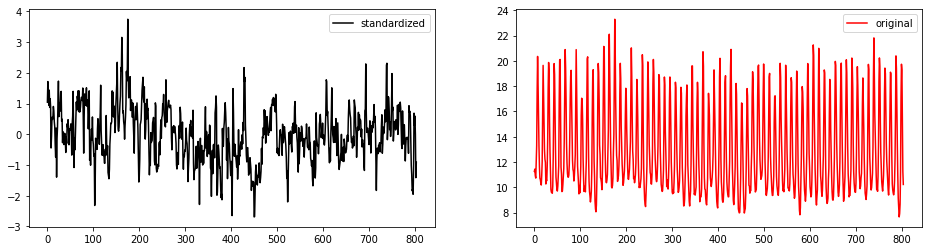

In [9]:
#plot the standardized and original time series for one location -- Look at your data!!
f=plt.figure(figsize=(16,4))
gs=GridSpec(1,2)
plt.subplot(gs[0,0]);
plt.plot(Y_stand[:,4012],label='standardized',color='black');
plt.legend();
plt.subplot(gs[0,1]);
plt.plot(pacts.values.reshape(a,b*c)[:,4012],label='original',color='red');
plt.legend();

In [10]:
print('spot check of Y_stand at one location:')
print(Y_stand[0:100,4012])

spot check of Y_stand at one location:
[ 1.0478193   1.7183979   1.3283141   0.9486724   1.4392076   0.8758037
  1.1622597   0.8919142  -0.44509503 -0.05890786  0.5547204   0.48426127
  0.52406615  0.9073797   0.7649223   0.41521826  0.24459232 -0.34876564
 -0.7423605   0.20451732 -1.39414    -0.13813616  0.23271346  1.0309212
  1.7326818   0.5757336   1.0100042   0.7479022   1.0137852   1.3839101
  1.3978199   0.4268153   0.49350518 -0.27311978  0.08140874  0.05459519
 -0.3336149  -0.05385359  0.0282828  -0.21732976 -0.5906749  -0.08149562
 -0.29671922  0.34265414  0.22546372  0.47681803  0.16427493 -0.3405945
  0.13417289  0.17537428  0.14497422  0.33975643  0.1588171  -0.6756741
  0.33529234  0.5887516   1.39938     0.12888876 -1.0812598  -0.11889586
 -0.50384074  0.04137945  0.63816816  1.0543919   0.7905863   1.2405472
  1.1287334   1.4194059   0.74279934  1.4135923   0.7231195   0.7455282
  0.8859661   1.1119072   1.2056538   1.1835731   1.1010145   1.5074518
  0.59080225 -0.6115

In [11]:
### STEP #2 - Calculate the EOFs -- Using eigenanalysis of the covariance matrix (the np.linalg.eig method)

#calculate covariance matrix
C = 1./np.size(Y_stand,axis = 0)*np.dot(np.transpose(Y_stand),Y_stand) ## Barnes Chapter 3 Equation 7
print(np.shape(Y_stand))
print(np.shape(C))

#get eigenvalues and eigenvectors - linear algebra module method - will take a couple of minutes
start_time = timeit.default_timer()
lam, E = LA.eig(C) ## Barnes Chapter 3 Equation 42
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA eigenvalue method: ',elapsed, 'seconds')

#order by eigenvalues and eigenvectors by eigenvalues
ii=np.flipud(np.argsort(lam))
lam=lam[ii]
E=E[:,ii]

(804, 7248)
(7248, 7248)
Time elapsed in LA eigenvalue method:  120.77075139340013 seconds


In [12]:
### STEP #2 - Calculate the EOFs -- Using Singular Value Decomposition (SVD) (the np.linalg SVD method)
### Why is this method so much faster?  Ah, an unsolved mysteries of ATOC5860...
start_time = timeit.default_timer()
u,s,v=LA.svd(Y_stand)  ## Barnes Chapter 3 Equation (65)
elapsed = timeit.default_timer() - start_time
print('Time elapsed in LA SVD method: ',elapsed,' seconds')

Time elapsed in LA SVD method:  5.212120793759823  seconds


804
(804,)
lag1 autocorrelation from np.correlate: 0.886
[2.0323727e+01 1.2588224e+01 1.1148353e+01 ... 1.8716575e-07 1.8777160e-07
 1.8806472e-07]


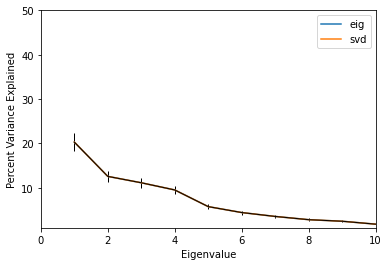

In [19]:
### STEP #3 - Plot the eigenvalues from both methods including errors bars following North et al. 1982.

# convert eigenvalues to percent variance explained
pve = 100.*np.abs(lam)/np.sum(np.abs(lam))
pve2 = 100.*np.abs(s**2)/np.sum(np.abs(s**2))
##print(pve2[0:10]-pve[0:10])

f=plt.figure()
plt.plot(np.arange(1,len(pve)+1),pve,label='eig');
plt.plot(np.arange(1,len(pve2)+1),pve2,label='svd')
plt.ylim([1,50])
plt.xlim([1,10])
plt.ylabel('Percent Variance Explained')
plt.xlabel('Eigenvalue')
plt.legend()

Nstar = np.size(Y_stand,axis = 0) ## assume all data is independent (not a great assumption, how do we do better?)
print(Nstar)
###  could for example - find the effective sample size using the average of all data
###  Caution: Use the data that went into the EOF analysis for this calculation, not the original data...
tseries=np.nanmean(np.nanmean(pactsanomstdwgt,axis=2),axis=1)  ## warning from land nans, ignore it!
print(np.shape(tseries))
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
N=len(tseries)         ## calculate the length of the timeseries
lag=1
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean
alpha=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(sigma**2)
print('lag1 autocorrelation from np.correlate:',round(alpha[0],3))
### Calculate the effective sample size (Nstar) for this data
### To estimate the number of independent samples - use Chapter 2 Barnes Eq. 88
Nstar=np.round((1-alpha)/(1+alpha)*N,0)
eb = pve*np.sqrt(2./Nstar)  ## North 1982, Barnes Chapter 3 Equation 80
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black');
plt.xlim([0,10])
print(pve)

In [14]:
### STEP 4 - Plot the first EOF pattern and PC timeseries 

# select an EOF
eof_num=1

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(f'shape of e1 {np.shape(e1)}')

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(f'shape of z1: {np.shape(z1)}')

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
##print(np.shape(v),np.shape(s),np.shape(u))  ## uncomment to check the shapes of SVD output
e1_svd = (v[eof_num-1,:])
print(f'shape of e1_svd {np.shape(e1_svd)}')

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]  ##*(s[eof_num-1]) deleted
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(f'shape of z1_svd: {np.shape(z1_svd)}')

shape of e1 (7248,)
shape of z1: (804,)
shape of e1_svd (7248,)
shape of z1_svd: (804,)


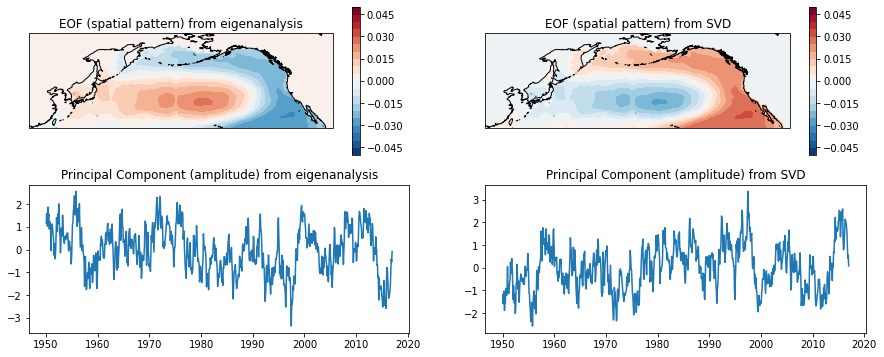

In [15]:
### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(15,6))
gs=GridSpec(2,2)

ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
CS=ax.contourf(lon,lat,e1.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF (spatial pattern) from eigenanalysis')
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(time,(z1))
plt.title('Principal Component (amplitude) from eigenanalysis')
##plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
levels=levels+1e-14 ### cartopy weirdness not explained but at least it makes plots :)
CS=ax.contourf(lon,lat,np.real(e1_svd).reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]],ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF (spatial pattern) from SVD')
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(time,(z1_svd))
plt.title('Principal Component (amplitude) from SVD');

In [16]:
### STEP 5) Regress the data (unweighted data if applicable) onto standardize values of the PC 
### for eof_num above
      
# calculate d (EOF in physical units) for plotting
## d1 is in physical units (in this case degrees)  and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)  ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))

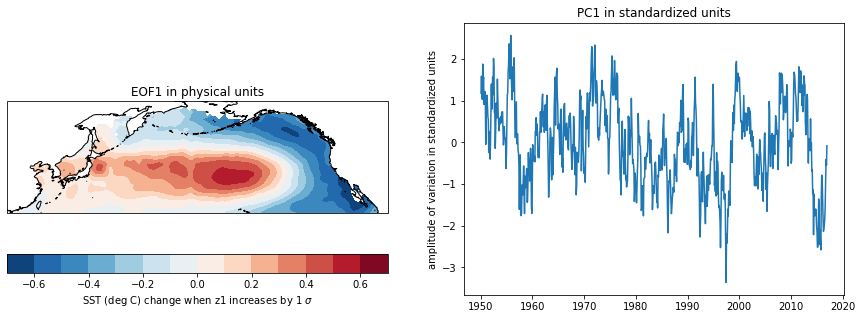

In [17]:
### Make a plot of the EOF in physical units and associated PC
f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-0.7,0.71,0.1)
levels2=levels2+1e-14 ### +1e-14 to deal with cartopy weirdness again
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('SST (deg C) change when z1 increases by 1 $\sigma$')
plt.title('EOF1 in physical units')
plt.subplot(gs[0,1])
plt.plot(time,z1)
plt.ylabel('amplitude of variation in standardized units');
plt.title('PC1 in standardized units');

shape of e1 (7248,)
shape of z1 (804,)
shape of e1_svd (7248,)
shape of z1_svd (804,)
(151, 48)


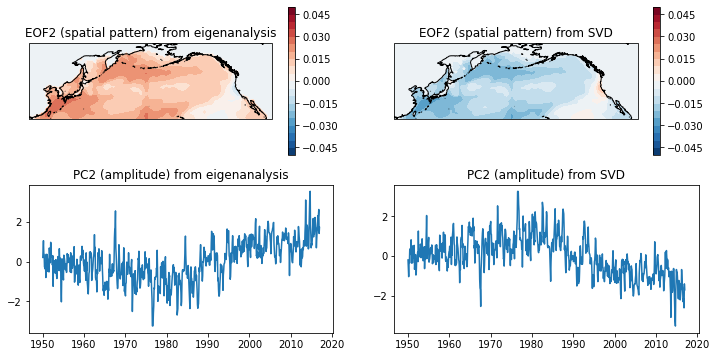

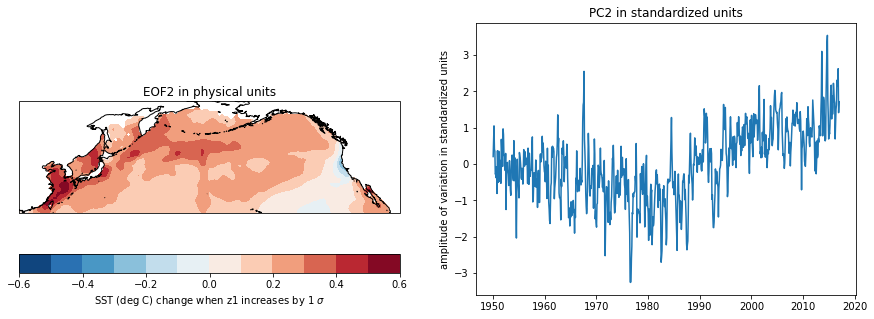

In [18]:
### Repeat STEP 4 and 5 for the second EOF  

#let's look at second eof
eof_num=2

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(f'shape of e1 {np.shape(e1)}')

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(f'shape of z1 {np.shape(z1)}')

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
##print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:]) ## reshape below -- removed .reshape(b,c)
print(f'shape of e1_svd {np.shape(e1_svd)}')

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]  ##removed *(s[eof_num-1])
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(f'shape of z1_svd {np.shape(z1_svd)}')

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(12,6))
gs=GridSpec(2,2)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
levels=levels+1e-14 ##cartopy weirdness
CS=ax.contourf(lon,lat,e1.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF2 (spatial pattern) from eigenanalysis');
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(time,(z1))
plt.title('PC2 (amplitude) from eigenanalysis');
#plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,e1_svd.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF2 (spatial pattern) from SVD');
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(time,(z1_svd))
plt.title('PC2 (amplitude) from SVD');

# calculate d for plotting in physical units, not standardized/weighted units.
## d1 is in physical units (in this case degrees) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)

# calculate d for plotting in standardized/weighted units
## d1 denotes the anomaly (in units degrees) associated with variation in 1 unit standard deviation of PC
## of z1 (principal component, time variation in this case)
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)  ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))

f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-0.6,0.61,0.1)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
print(np.shape(np.transpose(d1.reshape(b,c))))
CS=ax.contourf(lon,lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
#CS=m.contourf(x,y,d1plot,levels2,cmap=plt.cm.RdBu_r)
#m.drawcoastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('SST (deg C) change when z1 increases by 1 $\sigma$')
plt.title('EOF2 in physical units')

plt.subplot(gs[0,1])
plt.plot(time,z1)
plt.ylabel('amplitude of variation in standardized units');
plt.title('PC2 in standardized units');

shape of e1 (7248,)
shape of z1 (804,)
shape of e1_svd (7248,)
shape of z1_svd (804,)
(151, 48)


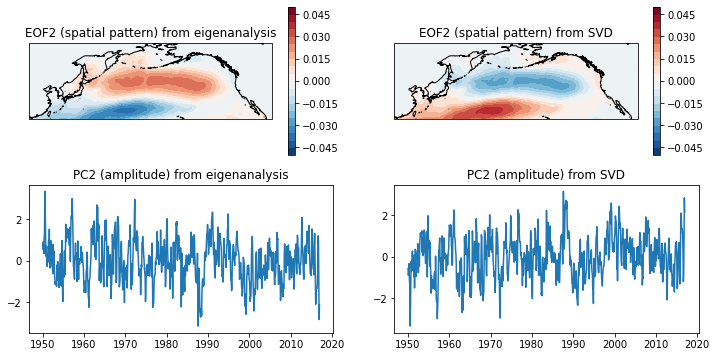

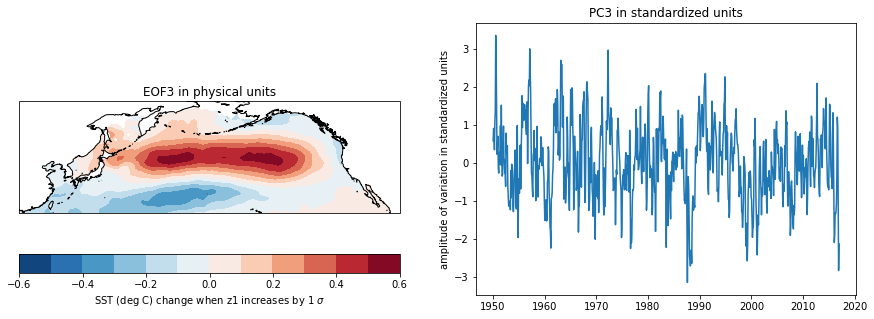

In [21]:
### Repeat STEP 4 and 5 for the second EOF  

#let's look at second eof
eof_num=3

# Find the eigenvector (e1) associated with "eof_num" from the eigenanalysis method
e1 = E[:,eof_num-1]
print(f'shape of e1 {np.shape(e1)}')

# Calculate the principal component (z1) associated with "eof_num" from the eigenanalysis method
z1 = np.dot(Y_stand,e1)  ## Barnes Chapter 3 Eq. (50)
## standardize it
z1 = (z1-np.mean(z1))/np.std(z1)  
print(f'shape of z1 {np.shape(z1)}')

# Find the eigenvector (e1_svd) associated with "eof_num" from the SVD method
##print(np.shape(v),np.shape(s),np.shape(u))
e1_svd = (v[eof_num-1,:]) ## reshape below -- removed .reshape(b,c)
print(f'shape of e1_svd {np.shape(e1_svd)}')

# Calculate the principal component (z1_svd) associated with "eof_num" from the SVD method
z1_svd = u[:,eof_num-1]  ##removed *(s[eof_num-1])
## standardize it
z1_svd = (z1_svd-np.mean(z1_svd))/np.std(z1_svd)  
print(f'shape of z1_svd {np.shape(z1_svd)}')

### Make a 4-panel plot showing the eigenvector (spatial pattern) and principal component (amplitude)

f=plt.figure(figsize=(12,6))
gs=GridSpec(2,2)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
#levels=np.arange(-0.1,0.11,0.01)
levels=np.arange(-0.05,0.051,0.005)
levels=levels+1e-14 ##cartopy weirdness
CS=ax.contourf(lon,lat,e1.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF2 (spatial pattern) from eigenanalysis');
plt.colorbar(CS)
plt.subplot(gs[1,0])
plt.plot(time,(z1))
plt.title('PC2 (amplitude) from eigenanalysis');
#plt.xlim([0,900])  ## when the first EOF is the seasonal cycle
ax=plt.subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180))
CS=ax.contourf(lon,lat,e1_svd.reshape(b,c),levels,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('EOF2 (spatial pattern) from SVD');
plt.colorbar(CS)
plt.subplot(gs[1,1])
plt.plot(time,(z1_svd))
plt.title('PC2 (amplitude) from SVD');

# calculate d for plotting in physical units, not standardized/weighted units.
## d1 is in physical units (in this case degrees) and denotes the anomaly associated with 1 standard deviation
## of z1 (principal component, time variation in this case)

# calculate d for plotting in standardized/weighted units
## d1 denotes the anomaly (in units degrees) associated with variation in 1 unit standard deviation of PC
## of z1 (principal component, time variation in this case)
d1 = (1./np.size(Y,axis=0))*np.dot(np.transpose(z1),Y)  ## Barnes Chapter 3 Equation (79)
#print(np.shape(d1))
d1plot = d1.reshape(b,c)  ### this is the reshaped eigenvector to plot
#print(np.shape(d1splot))

f=plt.figure(figsize=(15,5))
gs=GridSpec(1,2)
levels2=np.arange(-0.6,0.61,0.1)
ax=plt.subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180))
print(np.shape(np.transpose(d1.reshape(b,c))))
CS=ax.contourf(lon,lat,d1plot,levels2,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()
#CS=m.contourf(x,y,d1plot,levels2,cmap=plt.cm.RdBu_r)
#m.drawcoastlines()
cb=plt.colorbar(CS,orientation='horizontal')
cb.set_label('SST (deg C) change when z1 increases by 1 $\sigma$')
plt.title('EOF3 in physical units')

plt.subplot(gs[0,1])
plt.plot(time,z1)
plt.ylabel('amplitude of variation in standardized units');
plt.title('PC3 in standardized units');

## Notes

1. Provide a physical interpretation for at least the first two EOFs and principal components (PC). What do the EOFs (spatial patterns) tell you? What do the PC time series for the EOFs tell you? What do you think of the method for estimating the effective sample size (Nstar)? Can you propose an alternative way to estimate Nstar? Do you get the same results using eigenanalysis and SVD? If you got a different sign - do you think that is meaningful?

The first EOF represents the Pacific Decadal Oscillation (PDO), and its variance contribution is 20.3%. The corresponding PC shows PDO oscillates between positive and negative phases in decadal scale. The second EOF relates to the consistent warming of the Pacific Ocean and explains 12.6% of the variance. Its PC shows a significant warming trend since the 1990s. The method used to estimate N* assumes the data follows a first-order autoregressive process (red-noise). An alternative way to estimate N* is using Leith1973's method: $N^* = N \Delta t / 2 T_e$. The results from eigenanalysis and from SVD are the same. Their opposite signs still reprent the same thing since the relationship between the signs of EOF and PC are consistent. 

2. If not removing the seasonal cycle, the only dominant pattern (EOF1) and its PC will be the seasonal cycle and mask the other patterns that we are interested at. So, if we are aim at interannual or interdecadal SST patterns, removing the seasonal cycle is very useful and necessary. By removing the seasonal cycle, these interannual or interdecadal SST patterns that are originally weaker than the seasonal cycle can be shown. 

3. If detrending the data, then the original EOF2 - consistend warming pattern, is gone. Now both EOF1 and EOF2 seem to reprent PDO. EOF1 is more centered at the central Pacific and its variance contribution is larger (25.1%). So I think detrending the data is better when we don't want to analyze the consistent warming trend. 

4. If not applying the cosine weighting, the most significant difference is in EOF2, in which the pattern is stronger at higher latitude. This is because without cosine weighting, the variance of higher latitude is exaggerated. So I think cosine weighting is more important when the data covers a larger latitude range. 

5. Standarizing the data is useful when the data is made of a combination of parameters with different units, or the variance of the data varies greatly from space to space and this is not of interest. In our case, we have only one unit in our data, but the variance of the data does vary from space to space. So without standarizing, we see there are some changes of the spatial patterns of EOFs. It is more significant in EOF2, the consistent warming mode. I think the warming trend becomes stronger in higher latitude because the warming is stronger there. 

##### 